In [215]:
!pip install tensorboard

In [283]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
import datetime
import time
from tqdm import tqdm

from models.wideresnet import Wide_ResNet

In [217]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [218]:
datapath = "data/"
seed = 123

In [219]:
def get_normalization_params(dataset_name, datapath):
    """ Computes normalization params (means and stds) for a data set. In other sources these are hardcoded, just wanted to double-check.
    
    Parameters
    ----------
    dataset_name : str
        Name of the dataset.
    datapath : str
        Path to downloaded data sets.
    
    Returns
    -------
    tuple
        Tuple of numpy.ndarrays representing the means and the stds of the dataset.
    """
    if dataset_name == "cifar10":
        train_dataset = datasets.CIFAR10(os.path.join(datapath, dataset_name), train=True, transform=transforms.ToTensor(), download=True)
        # the mean of each pixel
        means = train_dataset.data.mean(axis=(0,1,2)) / 255.0
        # mean of the stds of each pixel across the channels
        stds = train_dataset.data.std(axis=(1,2)).mean(axis=0) / 255.0
        
    elif dataset_name == "cifar100":
        train_dataset = datasets.CIFAR100(os.path.join(datapath, dataset_name), train=True, transform=transforms.ToTensor(), download=True)
        # the mean of each pixel
        means = train_dataset.data.mean(axis=(0,1,2)) / 255.0
        # the std of each pixel
        stds = train_dataset.data.std(axis=(0,1,2)) / 255.0
    elif dataset_name == "clothing1m":
        pass
    else:
        raise Exception

    return means, stds

In [220]:
def make_inherent_label_noise(datapath, dataset_name, noise_mode, p, seed=None):
    """ Make inherent label noise.
    
    Parameters
    ----------
    datapath : str
        Path to downloaded data sets.
    dataset_name : str
        Name of the dataset.
    noise_mode : str
        sym, asym, openset, or dependent
    p : float
        The probability of noise / noise ratio for all of the noise_mode rule. All rules have the same noise ratio.
    seed : int
        Seed for reproducibility.
    
    Returns
    -------
    kwargs : dict
        Filenames as dict with keys per noise_mode: sym, asym -> labels_csv_path, noise_rules_csv_path, 
        openset -> labels_csv_path, noise_rules_csv_path, dataset_data_npy_path,
        dependent -> None, raises error, cannot make such noise
    """    
    # make inherent noise
    if noise_mode in ["sym", "asym"]:
        kwargs = make_inherent_label_noise_sym_asym(datapath=datapath, dataset_name=dataset_name, noise_mode=noise_mode, p=p, seed=seed)
    elif noise_mode == "openset":
        kwargs = make_inherent_label_noise_openset(datapath=datapath, dataset_name=dataset_name, noise_mode=noise_mode, p=p, seed=seed)
    elif noise_mode == "dependent":
        kwargs = make_inherent_label_noise_dependent(datapath=datapath, dataset_name=dataset_name, noise_mode=noise_mode, p=p, seed=None)
    else:
        raise Exception
        
    return kwargs
    
def make_inherent_label_noise_openset(datapath, dataset_name, noise_mode, p, seed=None):
    """ Make openset noise.
    
    Parameters
    ----------
    datapath : str
        Path to downloaded data sets.
    dataset_name : str
        Name of the dataset.
    noise_mode : str
        openset, here for consistency with the function make_inherent_label_noise_sym_asym
    p : float
        The probability of noise / noise ratio per rule. All rules have the same noise ratio.
    seed : int
        Seed for reproducibility.
    
    Returns
    -------
    noise_rules : list
        List of a single dict of noise rules.
    """
    if dataset_name == "cifar10":
        train_dataset = datasets.CIFAR10(os.path.join(datapath, dataset_name), train=True, transform=transforms.ToTensor(), download=True)
    else:
        raise Exception
    
    # get noise rules
    noise_rules = make_openset_noise_rules(dataset_name=dataset_name, p=p)
    # copy clean dataset images
    train_openset_dataset_data = np.copy(train_dataset.data)
    # collect indices into a set (could noise images at the same index, e.g.: flipping into a first dst dataset, then into a second dst dataset)
    indices_set = set()
    
    # only one noise rule for now, but keep loop for scalability
    for noise_rule in noise_rules:
        # get the indices where noisy images can be and the noisy images
        indices_per_rule, openset_data_per_rule = \
            make_openset_noise(train_dataset=train_dataset, src=noise_rule["src"], dst=noise_rule["dst"], p=noise_rule["p"], seed=seed)
        # collect the indices where noise could be
        indices_set.update(list(indices_per_rule))
        # insert potentially noisy images to training dataset and indices
        # note that if there were more noise rules, an original clean image could flip multiple times into a dst dataset image
        train_openset_dataset_data[indices_per_rule] = openset_data_per_rule
    
    # set to list
    indices = list(indices_set)
    # label_noisy is indicator vector of potentially noisy (True) and surely clean (False) indices of images 
    labels_noisy = np.array([False for i in range(len(train_dataset))])    
    labels_noisy[indices] = True
    
    # make class labels df and save as csv
    labels_df = pd.DataFrame(data={"label": train_dataset.targets, "label_noisy": labels_noisy})
    labels_csv_path = f"data/{dataset_name}/label_noisy/openset{p:.1f}_custom.csv" 
    labels_df.to_csv(labels_csv_path, index=False)
    print(f"{labels_csv_path} generated\n")
    
    # make noise rules df and save as csv
    noise_rules_df = pd.DataFrame(data=noise_rules)
    noise_rules_csv_path = f"data/{dataset_name}/label_noisy/openset{p:.1f}_noise_rules.csv"
    noise_rules_df.to_csv(noise_rules_csv_path, index=False)
    print(f"{noise_rules_csv_path} generated\n")
    
    # save the noisy train_openset_dataset_data (numpy.ndarray) taht will be loaded later into train_dataset.data
    dataset_data_npy_path = f"data/{dataset_name}/label_noisy/openset{p:.1f}_custom.npy"
    np.save(dataset_data_npy_path, train_openset_dataset_data)
    print(f"{dataset_data_npy_path} generated\n")
    
    return {
        "labels_csv_path": labels_csv_path,
        "noise_rules_csv_path": noise_rules_csv_path,
        "dataset_data_npy_path": dataset_data_npy_path,
    }

def make_inherent_label_noise_dependent(datapath, dataset_name, noise_mode, p, seed=None):
    """ Make dependent label noise. Requires training a DNN so not implemented for now, use dependent noise from paper.
    
    Parameters
    ----------
    datapath : str
        Path to downloaded data sets.
    dataset_name : str
        Name of the dataset.
    noise_mode : str
        dependent, here for consistency with similar methods
    p : float
        The probability of noise / noise ratio per rule. All rules have the same noise ratio.
    seed : int
        Seed for reproducibility.
    
    Returns
    -------
    
    """
    raise NotImplementedError
    
    
def make_inherent_label_noise_sym_asym(datapath, dataset_name, noise_mode, p, seed=None):
    """ Make symmetric or asymmetric noise. Symmetric and asymmetric noise are similar in that class labels flip into some other class labels.
    In symmetric, a given class label flips into one of the rest of class labels in the dataset whereass in asymmetric noise a class
    label flips into some predefined class labels.
    
    Parameters
    ----------
    datapath : str
        Path to downloaded data sets.
    dataset_name : str
        Name of the dataset.
    noise_mode : str
        One of sym or asym for symmetric and asymmetric noise modes.
    p : float
        The probability of noise / noise ratio per rule. All rules have the same noise ratio.
    seed : int
        Seed for reproducibility.
    
    Returns
    -------
    noise_rules : list
        List of a single dict of noise rules.
    """
    # load train dataset
    if dataset_name == "cifar10":
        train_dataset = datasets.CIFAR10(os.path.join(datapath, dataset_name), train=True, transform=transforms.ToTensor(), download=True)
    elif dataset_name == "cifar100":
        train_dataset = datasets.CIFAR100(os.path.join(datapath, dataset_name), train=True, transform=transforms.ToTensor(), download=True)
    else:
        raise Exception
    # make noise rules
    if noise_mode == "sym":
        noise_rules = make_sym_noise_rules(dataset_name=dataset_name, train_dataset=train_dataset, p=p)
    elif noise_mode == "asym":
        noise_rules = make_asym_noise_rules(dataset_name=dataset_name, train_dataset=train_dataset, p=p)
    else:
        raise Exception
    # get class labels of dataset and copy into noisy_targets
    targets = torch.tensor(train_dataset.targets)
    noisy_targets = targets.detach().clone()
    
    # get noisy class labels per noise rule (symmetric will have multiple noise_rule dicts, asymmetric will have one)
    for noise_rule in noise_rules:
        # get noisy indices of class labels, the noisy class labels at those indices
        indices_per_rule, noisy_targets_per_rule = \
            make_sym_asym_noise(train_dataset=train_dataset, src=noise_rule["src"], dsts=noise_rule["dsts"], p=noise_rule["p"], seed=seed)
        # replace correct class labels with per rule noisy ones
        noisy_targets[indices_per_rule] = noisy_targets_per_rule
        
    # make df of correct and noisy labels, and save as csv
    labels_df = pd.DataFrame(data={"label": targets.numpy(), "label_noisy": noisy_targets.numpy()})
    labels_csv_path = f"data/{dataset_name}/label_noisy/{noise_mode}{p:.1f}_custom.csv"
    labels_df.to_csv(labels_csv_path, index=False)
    print(f"{labels_csv_path} generated\n")
    
    # make df of noise rules used in geenrating the noisy class labels
    noise_rules_df = pd.DataFrame(data=noise_rules)
    noise_rules_csv_path = f"data/{dataset_name}/label_noisy/{noise_mode}{p:.1f}_noise_rules.csv"
    noise_rules_df.to_csv(noise_rules_csv_path, index=False)
    print(f"{noise_rules_csv_path} generated\n")
    
    return {
        "labels_csv_path": labels_csv_path,
        "noise_rules_csv_path": noise_rules_csv_path
    }
        
    
def make_sym_asym_noise(train_dataset, src, dsts, p, seed=None):
    """ Add symmetric or asymmetric noise to the targets based on a noise_rule dict with src, dsts and p (and seed).
    
    Parameters
    ----------
    train_dataset : torchvision.datasets.x.x
        The training dataset split, e.g.: torchvision.datasets.cifar.CIFAR10
    src : str
        Correct class label.
    dsts : list
        List of strs representing class labels one of which to the original correct class label will flip with probability p. 
    p : float
        The probability of noise / noise ratio per rule. All rules have the same noise ratio.
    seed : int
        Seed for reproducibility.
    
    Returns
    -------
    tuple
        Of indices, noisy_targets_sub representing the indices where flipping coud have happened (no matter if it did or not) and
        noisy_targets_sub are the noisy class labels (that can contain the original clean ones as well as teh noisy ones)
    """
    # set seed for reprodcuibility
    if seed is not None:
        torch.manual_seed(seed)
    
    # clean targets
    targets = torch.tensor(train_dataset.targets)

    # get all labels
    labels = torch.tensor(list(train_dataset.class_to_idx.values()))
    labels_len = torch.tensor(labels.size(dim=0))

    # get src targets indices (indices in the entire dataset) that will be flipped
    indices = torch.where(targets == train_dataset.class_to_idx[src])[0]

    # p_mask eg 0.4 for each src target, each target flips with probability p (a vector of length train_dataset.size) with values p
    p_mask = torch.ones_like(targets[indices]) * p
    # flip_mask is 0s and 1s  (flip is 1s) of lenght train_dataset.size
    flip_mask = torch.bernoulli(input=p_mask)

    # keep_mask is inverse of flip_mask (keep is 1s)
    keep_mask = (flip_mask * (-1)) + 1

    # p_mask_label is dst label probability distribution to flip to (length is number of classes), sums to 1.0
    # asym: dst class is 1.0, all else 0.0
    # sym: dsts are uniform
    p_mask_label = torch.zeros_like(labels, dtype=torch.float)
    p_mask_label[[train_dataset.class_to_idx[dst] for dst in dsts]] = 1.0 / len(dsts)

    # flip_mask_label is categorical distribution with params p_mask_label for each dst class
    flip_mask_label = torch.distributions.categorical.Categorical(p_mask_label)

    # flipped_targets is dst labels for each src label that the src label can flip to
    # asym: for now, only one dst, so all in flip_targets is dst class label
    # sym: class labels to which the src label can flip
    flipped_targets = flip_mask_label.sample(sample_shape=targets[indices].shape)

    # mask the flipped_targets to get the actually flipped instances (ones not to be flipped are 0s, ones to be flipped are dst labels)
    masked_flipped_targets = flipped_targets * flip_mask

    # mask the actual targets to keep the ones not flipped (ones not to be flipped are original labels, ones to be flipped are 0s)
    masked_targets = targets[indices] * keep_mask

    # add vectors together - kept ones remain, flipped ones are flipped
    noisy_targets_sub = (masked_targets + masked_flipped_targets).long()
    
    return indices, noisy_targets_sub

def make_openset_noise(train_dataset, src, dst, p, seed=None):
    """ Add openset noise to the images of the train dataset based on a noise_rule dict with src, dst and p (and seed).
    NOTE THAT THE SRC AND THE DST DATASETS ARE ASSUMED TO INCLUDE IMAGES OF THE SAME SIZE.
    
    Parameters
    ----------
    train_dataset : torchvision.datasets.x.x
        The training dataset split, e.g.: torchvision.datasets.cifar.CIFAR10
    src : str
        The dataset name to be noised.
    dst : str
        The dataset name including the images to be added as noise.
    p : float
        The probability of noise / noise ratio per rule. All rules have the same noise ratio.
    seed : int
        Seed for reproducibility.
    
    Returns
    -------
    tuple
        Of indices, noisy_targets_sub openset_data the indices where flipping coud have happened (no matter if it did or not) and
        openset_data are the noisy / out-of-distribution images (that can contain the original clean ones as well as the noisy ones)
    """
    # load the dst dataset
    if dst == "cifar100":
        dst_dataset = datasets.CIFAR100(os.path.join("data", "cifar100"), train=True, download=True)
    else:
        raise Exception
    
    if seed is not None:
        np.random.seed(seed)
    
    # select random images at indices to be flipped
    indices = np.random.choice(len(train_dataset), int(len(train_dataset) * p), replace=False)

    if seed is not None:
        np.random.seed(seed + 123)

    # get the noisy image indices
    indices_dst = np.random.choice(len(train_dataset), int(len(train_dataset) * p), replace=False)
    # get the noisy images
    openset_data = dst_dataset.data[indices_dst]
    
    assert train_dataset.data[indices].shape == openset_data.shape
    
    return indices, openset_data

In [221]:
def make_sym_noise_rules(dataset_name, train_dataset, p=0.4):
    """ Make symmetric noise rules. Noise rules are represented by a list of dicts. 
    Symmetric noise is defined as a class label flipping into any other class label (of all classes except the given class label) with equal probabilities.
    Each dict has keys src, dsts, and p. src is class to be noised/turn into one of dsts, 
    dsts is a list of classs of noise/src to be turned into, and p is the probability by which the src class label turns into one of dsts.
    The list of noise rules define the noising process of a dataset with name dataset_name of which train_dataset is the 
    train split of the dataset.
    
    Parameters
    ----------
    dataset_name : str
        Name of the dataset.
    train_dataset : torchvision.datasets.x.x
        The training dataset split, e.g.: torchvision.datasets.cifar.CIFAR10
    p : float
        The probability of noise / noise ratio per rule. All rules have the same noise ratio.
    
    Returns
    -------
    noise_rules : list
        List of dicts of noise rules.
    """
    if dataset_name in ["cifar10", "cifar100"]:
        labels = list(train_dataset.class_to_idx.keys())
        noise_rules = []

        for src in labels:
            dsts = labels.copy()
            dsts.remove(src)

            noise_rule = {"src":src, "dsts":dsts, "p":p}
            noise_rules.append(noise_rule)

    else:
        raise Exception
        
    return noise_rules

def make_asym_noise_rules(dataset_name, train_dataset, p=0.4):
    """ Make asymmetric noise rules. Noise rules are represented by a list of dicts. 
    Asymmetric noise is defined as a class label flipping into some other class labels (not all other but the given class label) with equal probabilities.
    Each dict has keys src, dsts, and p. src is class to be noised/turn into one of dsts, 
    dsts is a list of classs of noise/src to be turned into, and p is the probability by which the src class label turns into one of dsts.
    The list of noise rules define the noising process of a dataset with name dataset_name of which train_dataset is the 
    train split of the dataset.
    
    Parameters
    ----------
    dataset_name : str
        Name of the dataset.
    train_dataset : torchvision.datasets.x.x
        The training dataset split, e.g.: torchvision.datasets.cifar.CIFAR10
    p : float
        The probability of noise / noise ratio per rule. All rules have the same noise ratio.
    
    Returns
    -------
    noise_rules : list
        List of dicts of noise rules.
    """
    if dataset_name == "cifar10":
        noise_rules = [
            {"src":"truck", "dsts":["automobile"], "p":p},
            {"src":"bird", "dsts":["airplane"], "p":p},
            {"src":"cat", "dsts":["dog"], "p":p},
            {"src":"dog", "dsts":["cat"], "p":p}
        ]

    elif "cifar100":
        labels = np.array(list(train_dataset.class_to_idx.keys()))
        labels_shifted = np.roll(labels, 1)
        noise_rules = []
        for src, dst in zip(labels_shifted, labels):
            noise_rule = {"src":src, "dsts":[dst], "p":p}
            noise_rules.append(noise_rule)
    else:
        raise Exception
        
    return noise_rules

def make_openset_noise_rules(dataset_name, p=0.4):
    """ Make openset noise rules. Noise rules are represented as a list of a single dict.
    Openset noise is defined as the image having a certain class flipping into an out-of-distribution image (from other dataset)
    while preserving the original class label.
    Each dict has keys src, dst, and p. src is the dataset name to be openset noised.
    dst is the out-of-distribution dataset_name, and p is the probability by which images in dataset src turn into images of dst.
    
    Parameters
    ----------
    dataset_name : str
        Name of the dataset.
    p : float
        The probability of noise / noise ratio per rule. All rules have the same noise ratio.
    
    Returns
    -------
    noise_rules : list
        List of a single dict of noise rules.
    """
    if dataset_name == "cifar10":
        noise_rules = [{"src": dataset_name, "dst": "cifar100", "p": p}]
    else:
        raise Exception
        
    return noise_rules

In [222]:
def add_inherent_label_noise(train_dataset, datapath, dataset_name, noise_mode, p, custom):
    """ Add inherent label noise to train_dataset.
    
    Parameters
    ----------
    train_dataset : torchvision.datasets.x.x
        The training dataset split, e.g.: torchvision.datasets.cifar.CIFAR10
    datapath : str
        Path to downloaded data sets.
    dataset_name : str
        Name of the dataset.
    noise_mode : str
        sym, asym, openset, dependent
    p : float
        Noise ratio.
    custom : bool
        If True, make custom noise, else use from paper.
    
    Returns
    -------
    tuple
        Of train_dataset, indices_noisy, noise_rules where train_dataset is the noisy training dataset, indices_noisy is the indices of 
        noisy labels, and noise_rules is a df of the noise rules applied to the train dataset
    """
    # sym or asym noise, can be from paper or custom
    if noise_mode in ["sym", "asym"]:
        labels_csv_path = \
            f"data/{dataset_name}/label_noisy/{noise_mode}{p:.1f}_custom.csv" if custom else f"data/{dataset_name}/label_noisy/{noise_mode}{p:.1f}.csv"
        noise_rules_csv_path = f"data/{dataset_name}/label_noisy/{noise_mode}{p:.1f}_noise_rules.csv"
        
        noise_rules = pd.read_csv(noise_rules_csv_path)
        targets_noisy = list(pd.read_csv(labels_csv_path)["label_noisy"].values.astype(int))
        
        targets = train_dataset.targets
        indices_noisy = np.array([targets[i] != targets_noisy[i] for i in range(len(targets_noisy))])
        train_dataset.targets = targets_noisy
        
        print(f"adding inherent noise to {dataset_name}: {'custom' if custom else 'from paper'}, noise_mode:{noise_mode}, p:{p}")
        print(f"labels_csv_path:{labels_csv_path}, noise_rules_csv_path:{noise_rules_csv_path}")
    # openset noise, can NOT be from paper (not published) so only custom
    elif noise_mode == "openset" and custom:
        labels_csv_path = \
            f"data/{dataset_name}/label_noisy/{noise_mode}{p:.1f}_custom.csv"
        noise_rules_csv_path = f"data/{dataset_name}/label_noisy/{noise_mode}{p:.1f}_noise_rules.csv"
        dataset_data_npy_path = f"data/{dataset_name}/label_noisy/{noise_mode}{p:.1f}_custom.npy"
        
        noise_rules = pd.read_csv(noise_rules_csv_path)
        indices_noisy = pd.read_csv(labels_csv_path)["label_noisy"].values.astype(bool)
        train_dataset_data = np.load(dataset_data_npy_path)
        
        train_dataset.data = train_dataset_data.copy()
        
        print(f"adding inherent noise to {dataset_name}: {'custom' if custom else 'from paper'}, noise_mode:{noise_mode}, p:{p}")
        print(f"labels_csv_path:{labels_csv_path}, noise_rules_csv_path:{noise_rules_csv_path}, dataset_data_npy_path:{dataset_data_npy_path}")
    # dependent is only from paper
    elif noise_mode == "dependent" and not custom:
        labels_csv_path = \
            f"data/{dataset_name}/label_noisy/{noise_mode}{p:.1f}.csv"
        noise_rules_csv_path = None
        
        noise_rules = None
        targets_noisy = list(pd.read_csv(labels_csv_path)["label_noisy"].values.astype(int))
        
        targets = train_dataset.targets
        indices_noisy = np.array([targets[i] != targets_noisy[i] for i in range(len(targets_noisy))])
        train_dataset.targets = targets_noisy
        
        print(f"adding inherent noise to {dataset_name}: {'custom' if custom else 'from paper'}, noise_mode:{noise_mode}, p:{p}")
        print(f"labels_csv_path:{labels_csv_path}, noise_rules_csv_path:{noise_rules_csv_path}")
    else:
        raise Exception
        
    return train_dataset, indices_noisy, noise_rules

In [223]:
def show_imgs(datapath, dataset_name, train_dataset, noise_mode, indices_noisy, seed):
    """ Show image from a noisy dataset. 
    
    Parameters
    ----------
    datapath : str
        Path to downloaded data sets.
    dataset_name : str
        Name of the dataset.
    train_dataset : torchvision.datasets.x.x
        The training dataset split, e.g.: torchvision.datasets.cifar.CIFAR10
    noise_mode : str
        sym, asym, openset, dependent
    indices_noisy : list
        Boolean list of Trues (noisy) and Falses (clean)
    seed : int
        Seed for reproducibility.
    
    Returns
    -------
    None
    """
    # get the clean class labels in the taining dataset
    class_to_idx_list=list(train_dataset.class_to_idx.keys())
    
    # load the same training dataset for visualization pruposes
    if dataset_name == "cifar10":
        train_dataset_viz = datasets.CIFAR10(os.path.join(datapath, dataset_name), train=True, transform=transforms.ToTensor(), download=True)
    elif dataset_name == "cifar100":
        train_dataset_viz = datasets.CIFAR100(os.path.join(datapath, dataset_name), train=True, transform=transforms.ToTensor(), download=True)
    
    # get the clean targets and the clean data (not noisy) for viz purposes
    targets_clean = train_dataset_viz.targets
    train_dataset_viz.targets = train_dataset.targets
    train_dataset_viz.data = train_dataset.data
    
    # get the indices of noisy and clean instances
    indices_noisy_args = np.argwhere(indices_noisy).flatten()
    indices_clean_args = np.argwhere(indices_noisy == False).flatten()
    
    # plt stuff
    figure = plt.figure(figsize=(8*3, 8))
    cols, rows = 4*2, 4
    half = int(cols * rows / 2)
    
    # plot images
    for i in range(1, cols * rows + 1):
        # the sample indices for images with clean and noisy labels
        # noisy
        if half < i:
            np.random.seed(seed+i)
            sample_idx = np.random.choice(indices_noisy_args, 1, replace=False)[0]
        # clean
        else:
            np.random.seed(seed+i)
            sample_idx = np.random.choice(indices_clean_args, 1, replace=False)[0]
        
        # get clean image and label for sample indices
        img, label = train_dataset_viz[sample_idx]
        figure.add_subplot(rows, cols, i)
        
        # if noisy, add clean label too
        if half < i:
            # sym, asym, and dependet are class label flips
            if noise_mode in ["sym", "asym", "dependent"]:
                plt.title(f"dirty:{class_to_idx_list[label]} ({class_to_idx_list[targets_clean[sample_idx]]})")
            # openset is image flip so label is same as in original dataset but image flipped to out-of-dist images
            elif noise_mode  == "openset":
                plt.title(f"dirty:({class_to_idx_list[label]})")
        # clean
        else:
            plt.title(f"clean:{class_to_idx_list[label]}")
            
        plt.axis("off")
        # pytorch has dimension differently from what plt expects so permute first
        plt.imshow(img.permute(1, 2, 0))
    
    plt.show()

In [224]:
def check_combos(dataset_name, noise_mode, custom_noise):
    """ Check combos of dataset_name, noise_mode, and whether custom made or used from paper.
    
    Parameters
    ----------
    dataset_name : str
        Name of the dataset.
    noise_mode : str
        dependent, here for consistency with similar methods
    custom_noise : bool
        If True, make custom noise, else use from paper.
    
    Returns
    -------
    None
    """
    cond_fail_1 = custom_noise and dataset_name in ["cifar10", "cifar100"] and noise_mode == "dependent"
    cond_fail_2 = dataset_name == "cifar100" and noise_mode == "openset"
    cond_fail_3 = dataset_name == "cifar10" and noise_mode == "openset" and not custom_noise
    cond_fail = cond_fail_1 or cond_fail_2 or cond_fail_3
    assert not cond_fail, f"Incorrect combo: dataset_name:{dataset_name}, noise_mode:{noise_mode}, custom_noise:{custom_noise}"

## CIFAR-10

### Sym

Files already downloaded and verified
Files already downloaded and verified
adding inherent noise to cifar10: custom, noise_mode:openset, p:0.4
labels_csv_path:data/cifar10/label_noisy/openset0.4_custom.csv, noise_rules_csv_path:data/cifar10/label_noisy/openset0.4_noise_rules.csv, dataset_data_npy_path:data/cifar10/label_noisy/openset0.4_custom.npy
dataset_name:cifar10, noise_mode:openset, noise_ratio:0.4000
noise_rules
       src       dst    p
0  cifar10  cifar100  0.4
[False  True False ... False False  True]
Files already downloaded and verified


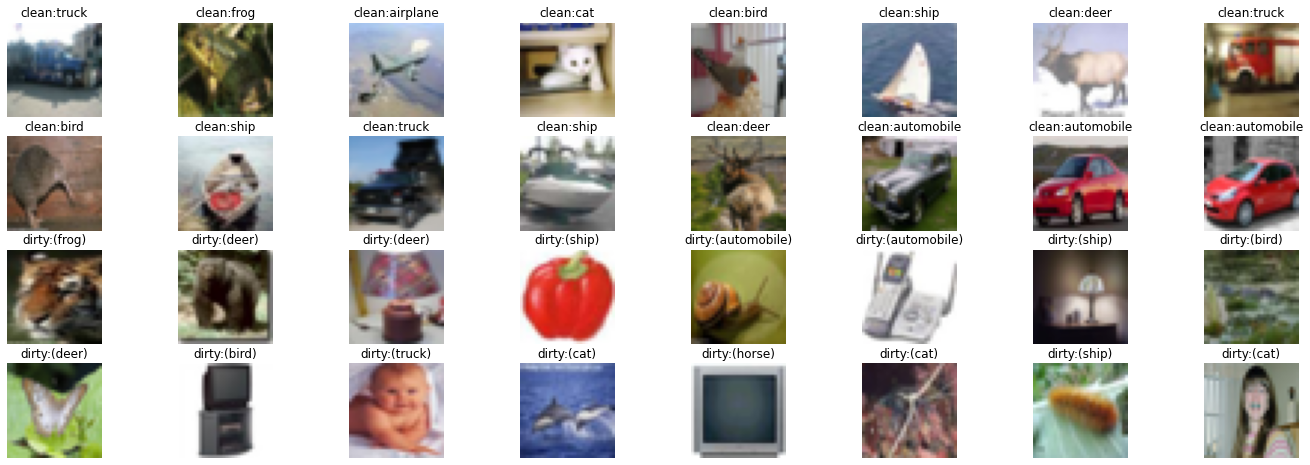

In [323]:
# dataset_names ["cifar10", "cifar100"]
# noise_modes ["sym", "asym", "openset", "dependent"]
# p any probability fro noise to 1 decimal, e.g.: 0.3, 0.6
# custom_noise if True, use custom noise (not by authors in GitHub), else from their GitHub
# make_new_custom_noise if True, make custom noise files

dataset_name = "cifar10"
noise_mode = "openset"
p = 0.4
custom_noise = True
make_new_custom_noise = False

check_combos(dataset_name, noise_mode, custom_noise)

if dataset_name == "cifar10":
    means, stds = get_normalization_params(dataset_name=dataset_name, datapath=datapath)
    
    train_transform = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize(means, stds)])

    test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(means, stds)])

    train_dataset = datasets.CIFAR10(os.path.join(datapath, dataset_name), train=True, transform=train_transform, download=True)
    test_dataset = datasets.CIFAR10(os.path.join(datapath, dataset_name), train=False, transform=test_transform)

elif dataset_name == "cifar100":
    means, stds = get_normalization_params(dataset_name=dataset_name, datapath=datapath)
    
    train_transform = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize(means, stds)])

    test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(means, stds)])

    train_dataset = datasets.CIFAR100(os.path.join(datapath, dataset_name), train=True, transform=train_transform, download=True)
    test_dataset = datasets.CIFAR100(os.path.join(datapath, dataset_name), train=False, transform=test_transform)
else:
    raise Exceptiion

if make_new_custom_noise:
    make_inherent_label_noise(
        datapath=datapath, 
        dataset_name=dataset_name, 
        noise_mode=noise_mode, 
        p=p, 
        seed=seed
    )

train_dataset, indices_noisy, noise_rules = add_inherent_label_noise(train_dataset, datapath, dataset_name, noise_mode, p, custom_noise)

print(f"dataset_name:{dataset_name}, noise_mode:{noise_mode}, noise_ratio:{indices_noisy.sum() / len(train_dataset.targets):.4f}")
print("noise_rules")
print(noise_rules)
print(indices_noisy)


###############

show_imgs(
    datapath=datapath, 
    dataset_name=dataset_name, 
    train_dataset=train_dataset,
    noise_mode=noise_mode,
    indices_noisy=indices_noisy,
    seed=seed
)

### Questions

- openset: cifar10 and cifar100 have overlapping classes, still in openset noise it is disregarded. what if we accidentally swap a dog in cifar10 for a dog in cifar100?
- openset: swapping transformed images in cifar10 to un-transformed in cifar100?
- normalization parameters?

In [345]:
class WeightEMA(object):
    def __init__(self, model, ema_model, alpha=0.999):
        self.model = model
        self.ema_model = ema_model
        self.alpha = alpha
        self.params = list(model.state_dict().values())
        self.ema_params = list(ema_model.state_dict().values())
        #self.wd = 0.02 * args.lr

        for param, ema_param in zip(self.params, self.ema_params):
            param.data.copy_(ema_param.data)

    def step(self):
        one_minus_alpha = 1.0 - self.alpha
        for param, ema_param in zip(self.params, self.ema_params):                   
            # fix the error 'RuntimeError: result type Float can't be cast to the desired output type Long'
            #print(param.type())
            if param.type()=='torch.cuda.LongTensor':
                ema_param = param
            else:
                ema_param.mul_(float(self.alpha))
                ema_param.add_(param * one_minus_alpha)
            # customized weight decay
            #param.mul_(1 - self.wd)


In [346]:
def get_model(model_name, n_classes, device):
    if model_name == "wrn-28-2":
        model = Wide_ResNet(num_classes=n_classes).to(device=device)
    else:
        raise Exception
    return model

In [347]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

batch_size = 128

#train_dataset.data = train_dataset.data[:500]
#test_dataset.data = test_dataset.data[:500]
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
train_eval_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

Using cpu device


In [348]:
train_dataset.data[:100].shape

(100, 32, 32, 3)

In [349]:
def one_hot_encode(targets, n_classes, dtype_int):
    """One-hot encode a batch of targets.
    
    Parameters
    ----------
    targets : list
        List of integers representing class labels. Of length len(targets).
    n_classes : int
        The number of classes in the dataset.
    dtype_int : bool
        If True, targets are of data type float, else of int. SLN perturbes labels so needed data type is float.
    
    Returns
    -------
    torch.Tensor
        One-hot encoded target vectors. The tensor is 2d and is of shape (len(targets), n_classes)
    """
    return torch.tensor(np.eye(n_classes)[targets], dtype=torch.int32 if dtype_int else torch.float)

In [350]:
n_classes = len(list(train_dataset.class_to_idx.keys()))

# noisy_targets to one-hot encoded vecs
noisy_targets = train_dataset.targets
noisy_targets = np.eye(n_classes)[noisy_targets]
print(noisy_targets.shape)
print(noisy_targets)
print(torch.tensor(noisy_targets))

(50000, 10)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]], dtype=torch.float64)


In [351]:
model_name = "wrn-28-2"
model = get_model(model_name=model_name, n_classes=n_classes, device=device)
#print(model)

model_ema = get_model(model_name=model_name, n_classes=n_classes, device=device)
optimizer_ema = WeightEMA(model, model_ema, alpha=0.999)

| Wide-Resnet 28x2
| Wide-Resnet 28x2


In [352]:
lr = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
#print(optimizer)

In [353]:
def train_loop(model, device, train_dataloader, optimizer, optimizer_ema, sigma, n_classes, n_epoch, n_epochs):
    # train mode for model e.g.: dropout, batch norm etc
    model.train()
    
    # record loss per epoch
    loss_epoch_sum = 0.0
    correct_predictions_epoch_sum = 0
    
    # n instances in training set
    n_batches = len(train_dataloader)
    n_data = len(train_dataloader.dataset)
    
    # tqdm
    train_dataloader_tqdm = tqdm(enumerate(train_dataloader), total=n_batches)
    train_dataloader_tqdm.set_description(f"staring epoch={n_epoch+1}/{n_epochs}")
    
    for n_batch, (data_batch, targets_batch) in train_dataloader_tqdm:
        batch_size = data_batch.size(0)
        # one-hot encode batch of labels
        targets_batch_one_hot = one_hot_encode(targets=targets_batch, n_classes=n_classes, dtype_int=False)
        assert len(targets_batch.size()) == 1
        assert len(targets_batch_one_hot.size()) == 2
        # put data and targets onto device
        data_batch, targets_batch_one_hot = data_batch.to(device), targets_batch_one_hot.to(device)
        
        # if SLN/SLN-MO/SLN-MO-LC model
        if 0 < sigma:
            # make and add to targets sln of shape targets_batch_one_hot.size() = (batch_size, n_classes)
            targets_batch_one_hot += sigma*torch.randn(targets_batch_one_hot.size()).to(device)
        else:
            pass
        
        # get model logits
        logits_batch = model(data_batch)
        # get cross entropy (ce) loss, i.e.: negative log-lieklihood
        # use log of softmax for numerical stability and calucalte the cross entropy loss manually
        loss_batch = -torch.mean(torch.sum(F.log_softmax(logits_batch, dim=1)*targets_batch_one_hot, dim=1))
        # get predictions
        predictions_batch = logits_batch.argmax(dim=1, keepdim=True)
        # get correct predictions (boolean vector, True if correct), view predictions_batch as targets_batch
        correct_predictions_batch = predictions_batch.view_as(targets_batch).eq(targets_batch)
        correct_predictions_epoch_sum += correct_predictions_batch.sum().item()
        # accuracy of batch
        acc_batch = correct_predictions_batch.sum() / batch_size
        
        # zero out grads, b default their are accumulated over steps
        optimizer.zero_grad()
        # backprop to obtain grads for model params
        loss_batch.backward()
        # apply model params
        optimizer.step()
        # if SLN-MO/SLN-MO-LC model
        if optimizer_ema:
            optimizer_ema.step()
        
        # accumulate loss per batch, i.e.: add the loss per batch batch_size times
        # eventually mean is computed loss is computed by dividing by the datset size
        loss_epoch_sum += batch_size * loss_batch.item()
        
        # tqdm
        train_dataloader_tqdm.set_description(f"epoch={n_epoch+1}/{n_epochs}, batch={n_batch+1}/{n_batches}, loss_batch={loss_batch.item():.4f}, acc_batch={acc_batch.item():.4f}")
    
    # compute loss per epoch as the mean of the loss_batches
    loss_epoch = loss_epoch_sum / n_data
    # accuracy epoch
    accuracy_epoch = correct_predictions_epoch_sum / n_data
    
    return loss_epoch, accuracy_epoch

def test_loop(model, device, test_dataloader, optimizer, mode, n_classes, n_epoch, n_epochs, **kwargs):
    pass

In [354]:
# possible models:
# 1) baseline: CE - sigma=0, optimizer_ema=None, n_epoch_label_correction_onset=0
# 2) SLN: - 0<sigma n_epoch_label_correction_onset=0
# 3) SLN-MO: - 0<sigma, optimizer_ema!=None, n_epoch_label_correction_onset=0
# 4) SLN-MO-LC: - 0<sigma, optimizer_ema!=None, 0<n_epoch_label_correction_onset(=250 in paper)

n_epochs = 10
sigma = 1.0
n_epoch_label_correction_onset = 250

datetime_now = datetime.datetime.now()
exp_id = f"exp_{datetime_now}"

x = datetime.datetime.now()
writer = SummaryWriter(f"runs/{exp_id}/")

loss_epochs = []
accuracy_epochs = []

for n_epoch in range(n_epochs):
    
    # label-correction
    # if SLN-MO-LC model
    if n_epoch_label_correction_onset < n_epoch + 1:
        pass
    else:
        pass
    
    loss_epoch, accuracy_epoch = train_loop(
        model=model, 
        device=device,
        train_dataloader=train_dataloader,
        optimizer=optimizer,
        optimizer_ema=optimizer_ema,
        sigma=sigma,
        n_classes=n_classes,
        n_epoch=n_epoch,
        n_epochs=n_epochs)
    
    writer.add_scalar("loss/train", loss_epoch, n_epoch+1)
    writer.add_scalar("accuracy/train", accuracy_epoch, n_epoch+1)
    
    loss_epochs.append(loss_epoch)
    accuracy_epochs.append(accuracy_epoch)
    
    print(f"epoch={n_epoch+1}/{n_epochs}, loss_epoch={loss_epoch:.4f}, acc_epoch={accuracy_epoch:.4f}")
    
# Call flush() method to make sure that all pending events have been written to disk.
writer.flush()

staring epoch=1/10:   0%|          | 0/391 [00:02<?, ?it/s]


RuntimeError: result type Float can't be cast to the desired output type Long

In [ ]:
plt.plot(loss_epochs)